In [1]:
import torch
import matplotlib.pyplot as plt

from pythae.models import RHVAE, RHVAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST

print(torch.cuda.is_available())
torch.cuda.set_device("cuda:1")
print(torch.cuda.current_device())

/data/parietal/store3/work/pbarbara/anaconda3/envs/fugwenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
1


In [2]:
dataset_to_augment = "../data/processed/"
device = "cpu"
import glob, os
# Load all images
images = []
for ext in ["*.jpg", "*.png"]:
    for f in glob.glob(os.path.join(dataset_to_augment, ext)):
        images.append(f)
# Load images into a tensor
images = torch.stack([torch.from_numpy(plt.imread(f)).permute(2, 0, 1) for f in images])
print("Loaded {} images".format(len(images)))
# Normalize images
images = images / 255.0

training_images = images[:700].to(device)
validation_images = images[700:].to(device)
print(f"Training images shape: {training_images.shape}")
print(f"Validation images shape: {validation_images.shape}")

/tmp/ipykernel_29025/3677398845.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  images = torch.stack([torch.from_numpy(plt.imread(f)).permute(2, 0, 1) for f in images])


Loaded 811 images
Training images shape: torch.Size([700, 3, 512, 512])
Validation images shape: torch.Size([111, 3, 512, 512])


In [3]:
from torchvision import transforms
# Resize images to 64x64
transform = transforms.Compose([transforms.Resize((28, 28)), 
                                transforms.Grayscale(num_output_channels=1),
                                ])
training_images = torch.stack([transform(img) for img in training_images])
validation_images = torch.stack([transform(img) for img in validation_images])
print(f"Training images shape: {training_images.shape}")
print(f"Validation images shape: {validation_images.shape}")

/data/parietal/store3/work/pbarbara/anaconda3/envs/fugwenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Training images shape: torch.Size([700, 1, 28, 28])
Validation images shape: torch.Size([111, 1, 28, 28])


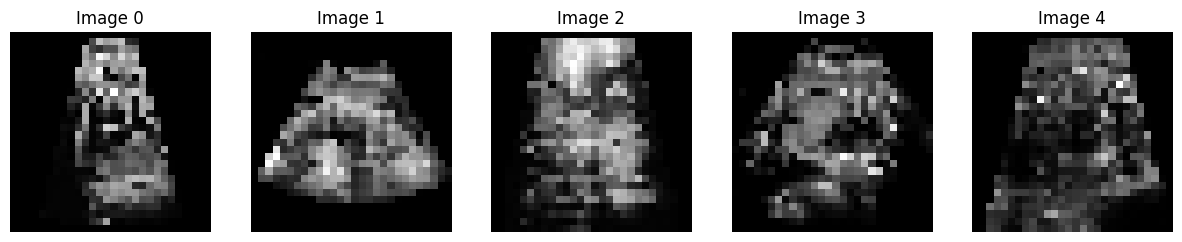

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(training_images[i].permute(1, 2, 0), cmap="gray")
    ax[i].set_title(f"Image {i}")
    ax[i].axis("off")
plt.show()

In [5]:
output_dir = "../models/rhvae/"
config = BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-4,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_epochs=100, # Change this to train the model a bit more
)


model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=64,
    reconstruction_loss="mse",
    n_lf=3,
    eps_lf=0.001,
    beta_zero=0.3,
    temperature=1.5,
    regularization=0.01

)

model = RHVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config), 
    decoder=Decoder_ResNet_AE_MNIST(model_config) 
)

In [6]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)
pipeline(
    train_data=training_images,
    eval_data=validation_images
)

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created ../models/rhvae/RHVAE_training_2023-11-10_16-48-54. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 100
 - per_device_eval_batch_size: 100
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Eval of epoch 1/100: 100%|██████████| 2/2 [00:00<00:00,  2.92batch/s]
--------------------------------------------------------------------------
Train loss: 99.6454
Eval loss: 28.8213
--------------------------------------------------------------------------
Eval of epoch 

In [7]:
import os
from pythae.models import AutoModel
last_training = sorted(os.listdir(output_dir))[-1]
trained_model = AutoModel.load_from_folder(os.path.join(output_dir, last_training, 'final_model'))

In [10]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig
# set up rhvae sampler config
rhvae_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr=100,
    n_lf=10,
    eps_lf=0.03
)

# create rhvae sampler
rhvae_sampler = RHVAESampler(
    sampler_config=rhvae_sampler_config,
    model=trained_model
)
# sample
gen_data = rhvae_sampler.sample(
    num_samples=25
)

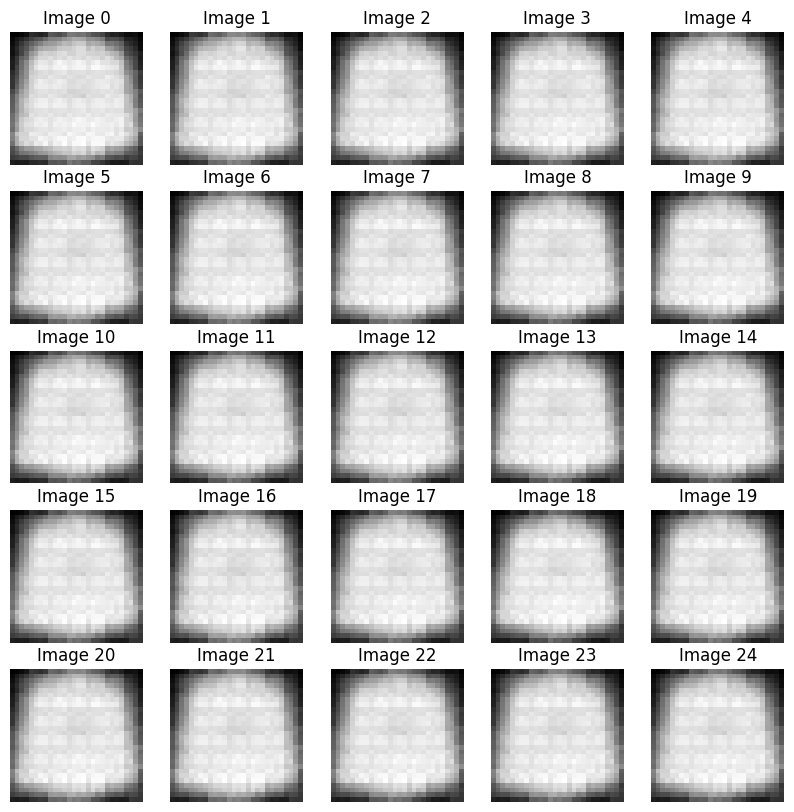

In [9]:
generated_samples = gen_data.cpu().detach()
# Plot the generated samples on a grid
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(generated_samples[i * 5 + j].permute(1, 2, 0), 'gray')
        ax[i, j].set_title(f"Image {i * 5 + j}")
        ax[i, j].axis("off")
plt.show()